# Introduction

Nividia Corporation is an American software and fabless company that design GPUs and APIs for data science and high performance computing as well as System on a Chip units(SoCs) for the mobile computing market. They are the main distributor of AI hardware and software. First, we would import the relevant python libraries and datasets that would be used in our analysis.

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import seaborn as sns

In [54]:
import tensorflow as tf

In [55]:
df=pd.read_csv(r"C:\Users\htaoh\Downloads\NVDA.csv", usecols = [0,1,2,3,4])
df["Date"] = pd.to_datetime(df["Date"],dayfirst = True)
interest_rate = pd.read_csv(r"C:\Users\htaoh\Downloads\FEDFUNDS.csv")
interest_rate["DATE"] = pd.to_datetime(interest_rate["DATE"],dayfirst = True)
df

,Date,Open,High,Low,Close
0,2019-01-02,32.660000,34.619999,32.512501,34.055000
1,2019-01-03,33.447498,33.790001,31.922501,31.997499
2,2019-01-04,32.735001,34.432499,32.424999,34.047501
3,2019-01-07,34.625000,36.222500,34.107498,35.849998
4,2019-01-08,36.672501,36.695000,34.224998,34.957500
...,...,...,...,...,...
1201,2023-10-10,453.100006,462.589996,450.880005,457.980011
1202,2023-10-11,461.959991,468.589996,460.500000,468.059998
1203,2023-10-12,467.769989,476.089996,463.299988,469.450012
1204,2023-10-13,469.600006,471.160004,452.799988,454.609985


# Factors affecting NVDA stock prices

There are numerous variables that would determine stock prices. However with this analysis, we would analyse 3 main factors: interest rate, inflation and Simple Moving Average(SMA). 

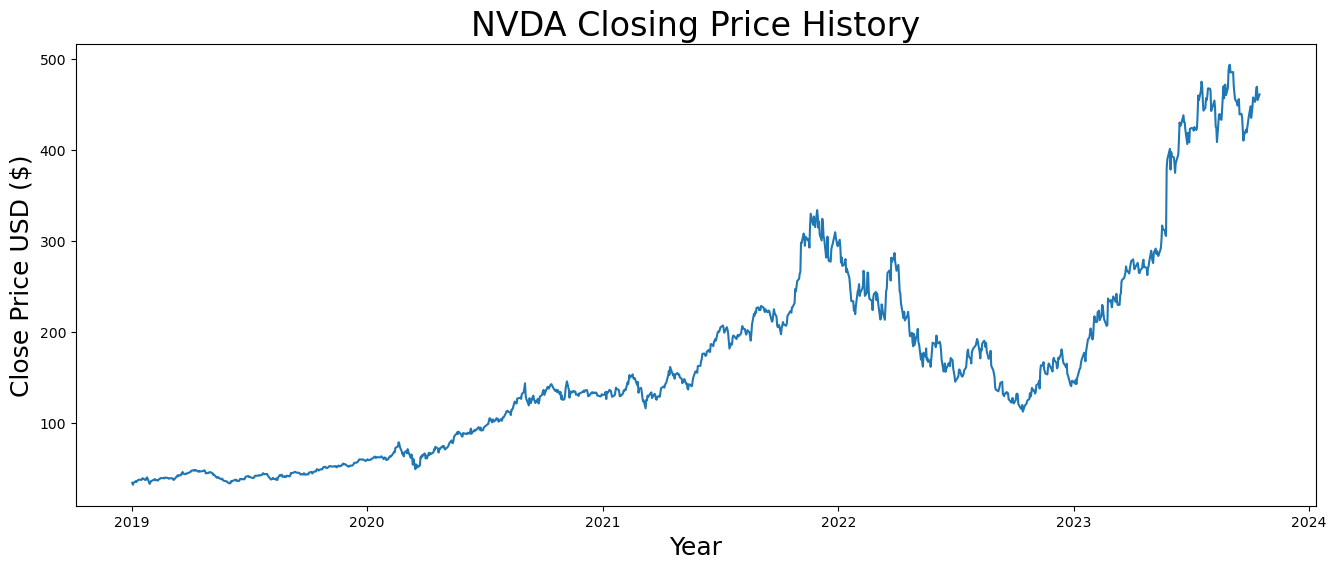

In [56]:
plt.figure(figsize=(16,6))
plt.title('NVDA Closing Price History', fontsize = 24)
plt.plot(df["Date"],df['Close'])
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.show()

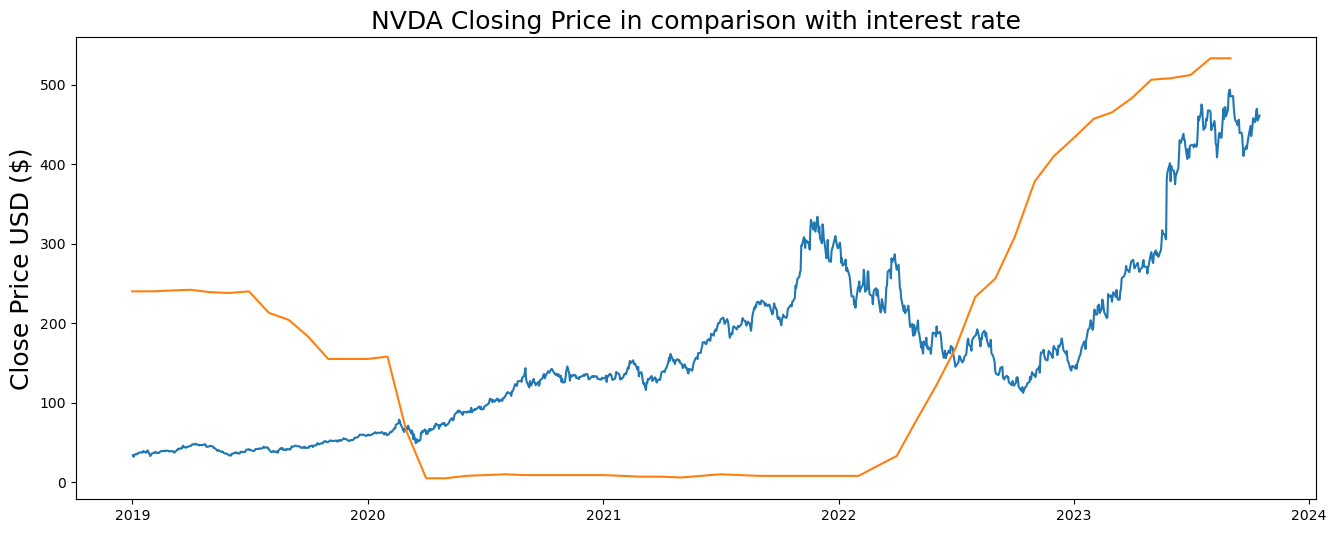

In [57]:
plt.figure(figsize=(16,6))
plt.title('NVDA Closing Price in comparison with interest rate', fontsize = 18)
plt.plot(df['Date'],df['Close'])
plt.plot(interest_rate['DATE'],interest_rate['FEDFUNDS (scaled by 100)'])
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

Higher interest rates tend to negatively affect earnings and stock prices. As interest rates increase, companies face higher cost of borrowing whilst seeing reduced consumer demand. With a lowered expectation in the growth and future cash flows of a company, investors will not get as much growth from stock price appreciation. This can make stock ownership less desirable and a fall of stock prices. From the graph, the orange line shows the interest rate while the blue line shows NVDA stock prices. From mid 2020 to mid 2022, a fall in interest rates saw a spike in NVDA stock prices. Nonetheless, a rise in stock prices is shown from mid 2022 which could be attributed to inflation.

# Appending Interest Rates Data into Historical Prices Data


In [58]:
df

,Date,Open,High,Low,Close
0,2019-01-02,32.660000,34.619999,32.512501,34.055000
1,2019-01-03,33.447498,33.790001,31.922501,31.997499
2,2019-01-04,32.735001,34.432499,32.424999,34.047501
3,2019-01-07,34.625000,36.222500,34.107498,35.849998
4,2019-01-08,36.672501,36.695000,34.224998,34.957500
...,...,...,...,...,...
1201,2023-10-10,453.100006,462.589996,450.880005,457.980011
1202,2023-10-11,461.959991,468.589996,460.500000,468.059998
1203,2023-10-12,467.769989,476.089996,463.299988,469.450012
1204,2023-10-13,469.600006,471.160004,452.799988,454.609985


In [59]:
df['Year-Month']=df['Date'].dt.to_period('M')
interest_rate['Year-Month']=interest_rate['DATE'].dt.to_period('M')
df_new = df.merge(interest_rate, on=['Year-Month'])
df_new

,Date,Open,High,Low,Close,Year-Month,DATE,FEDFUNDS,FEDFUNDS (scaled by 100)
0,2019-01-02,32.660000,34.619999,32.512501,34.055000,2019-01,2019-01-01,2.40,240
1,2019-01-03,33.447498,33.790001,31.922501,31.997499,2019-01,2019-01-01,2.40,240
2,2019-01-04,32.735001,34.432499,32.424999,34.047501,2019-01,2019-01-01,2.40,240
3,2019-01-07,34.625000,36.222500,34.107498,35.849998,2019-01,2019-01-01,2.40,240
4,2019-01-08,36.672501,36.695000,34.224998,34.957500,2019-01,2019-01-01,2.40,240
...,...,...,...,...,...,...,...,...,...
1190,2023-09-25,415.910004,425.359985,411.769989,422.220001,2023-09,2023-09-01,5.33,533
1191,2023-09-26,420.010010,428.200012,416.549988,419.109985,2023-09,2023-09-01,5.33,533
1192,2023-09-27,423.299988,428.720001,416.290009,424.679993,2023-09,2023-09-01,5.33,533
1193,2023-09-28,424.600006,434.459991,421.149994,430.890015,2023-09,2023-09-01,5.33,533


In [60]:
df_with_ir = df_new.drop(['Year-Month', 'DATE','FEDFUNDS (scaled by 100)'], axis=1)
df_with_ir.head()

,Date,Open,High,Low,Close,FEDFUNDS
0,2019-01-02,32.660000,34.619999,32.512501,34.055000,2.4
1,2019-01-03,33.447498,33.790001,31.922501,31.997499,2.4
2,2019-01-04,32.735001,34.432499,32.424999,34.047501,2.4
3,2019-01-07,34.625000,36.222500,34.107498,35.849998,2.4
4,2019-01-08,36.672501,36.695000,34.224998,34.957500,2.4


The Simple Moving Average is another important signal to consider. The SMA smoothes out volatility and makes it simpler to see a security's price trend. If SMA rises, it indicates that the security's price is rising vice versa. Traders use simple moving averages (SMAs) to chart a stock's or other security's long-term trend while disregarding the noise of day-to-day price swings. This enables traders to compare medium- and long-term patterns across a broader time frame.

In [61]:
df_with_ir["SMA_5"] = df_with_ir["Close"].transform(lambda x:x.rolling(5).mean())

In [62]:
df_with_ir = df_with_ir.dropna()
df_final = df_with_ir.drop(['Date',], axis=1)
df_final.head()

,Open,High,Low,Close,FEDFUNDS,SMA_5
4,36.672501,36.695000,34.224998,34.957500,2.4,34.181500
5,35.474998,36.122501,34.965000,35.645000,2.4,34.499500
6,35.450001,36.395000,34.840000,36.307499,2.4,35.361500
7,36.082500,37.437500,35.802502,37.207500,2.4,35.993499
8,36.680000,37.865002,36.442501,37.610001,2.4,36.345500


In [63]:
#find the min and max close price for min max scaling later on
min = df_final['Close'].min()
max = df_final['Close'].max()
min,max

(32.900002, 493.549988)

# Data Handling

In [64]:
#fit the data from range of (0,1) to fit into the model.
sc = MinMaxScaler(feature_range=(0,1))
df_final_scaled = sc.fit_transform(df_final)
print()

In [65]:
X = []
#number of days to look back into the past. 
days_to_reference = 30
print(df_final_scaled.shape[0])

#process the 5 rows of data into an array
for j in range(5):
    X.append([])
    for i in range(days_to_reference, df_final_scaled.shape[0]):
        X[j].append(df_final_scaled[i-days_to_reference:i, j])

X=np.moveaxis(X, [0], [2])
#yi is the target data. -3 refers to the 3rd last column which is the closing price, the column we have to predict. 
X, yi =np.array(X), np.array(df_final_scaled[days_to_reference:,-3])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

1191
[[[0.00641419 0.00497018 0.00322877 0.00446651 0.44507576]
  [0.00385812 0.00374766 0.00484863 0.00595897 0.44507576]
  [0.00380476 0.00432956 0.00457501 0.00739715 0.44507576]
  ...
  [0.01509095 0.01409375 0.01391108 0.01396938 0.44507576]
  [0.01186785 0.01196901 0.01375785 0.01358949 0.44507576]
  [0.01235346 0.01270039 0.01443097 0.01462607 0.44507576]]

 [[0.00385812 0.00374766 0.00484863 0.00595897 0.44507576]
  [0.00380476 0.00432956 0.00457501 0.00739715 0.44507576]
  [0.00515483 0.00655573 0.00668192 0.00935091 0.44507576]
  ...
  [0.01186785 0.01196901 0.01375785 0.01358949 0.44507576]
  [0.01235346 0.01270039 0.01443097 0.01462607 0.44507576]
  [0.01301515 0.01205443 0.01323249 0.01311733 0.44507576]]

 [[0.00380476 0.00432956 0.00457501 0.00739715 0.44507576]
  [0.00515483 0.00655573 0.00668192 0.00935091 0.44507576]
  [0.0064302  0.00746863 0.00808288 0.01022468 0.44507576]
  ...
  [0.01235346 0.01270039 0.01443097 0.01462607 0.44507576]
  [0.01301515 0.01205443 0.01

In [66]:
#split the data into train and test dataset.

split_ratio = int(len(X)*0.8)       # 80% train data, 20% test data
print(split_ratio)
X_train, X_test = X[:split_ratio], X[split_ratio:]
y_train, y_test = y[:split_ratio], y[split_ratio:]


928


# Model - LSTM 

The LSTM model effective in capturing patterns and dependencies in sequential time-dependent data. Furthermore, the LSTM model is able remember and forget the required historical data selectively as compared to other models such as the SVMs. This makes LSTM prediction more accurate. A multivariate LSTM is used to encompass the different variables that could impact stock prices such as interest rates and SMA.

In [67]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

In [68]:
np.random.seed(10)

#build the model. 
# lstm input shape(days_to_reference, and the number of columns we are looking back on)

lstm_input = Input(shape=(days_to_reference, 5), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
56/56 [==============================] - 6s 45ms/step - loss: 0.0050 - val_loss: 7.2067e-04
Epoch 2/30
56/56 [==============================] - 2s 31ms/step - loss: 4.5868e-04 - val_loss: 5.0593e-04
Epoch 3/30
56/56 [==============================] - 2s 32ms/step - loss: 4.5581e-04 - val_loss: 5.3036e-04
Epoch 4/30
56/56 [==============================] - 2s 31ms/step - loss: 4.0285e-04 - val_loss: 4.6524e-04
Epoch 5/30
56/56 [==============================] - 2s 31ms/step - loss: 3.7546e-04 - val_loss: 4.5761e-04
Epoch 6/30
56/56 [==============================] - 2s 32ms/step - loss: 3.5511e-04 - val_loss: 6.0081e-04
Epoch 7/30
56/56 [==============================] - 2s 32ms/step - loss: 3.3974e-04 - val_loss: 3.6213e-04
Epoch 8/30
56/56 [==============================] - 2s 32ms/step - loss: 3.1843e-04 - val_loss: 4.9667e-04
Epoch 9/30
56/56 [==============================] - 2s 32ms/step - loss: 3.2290e-04 - val_loss: 3.2830e-04
Epoch 10/30
56/56 [======================

In [69]:
#Predict the first 10 values of the test data.  
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

8/8 [==============================] - 1s 15ms/step
[0.19255593] [0.20853144]
[0.19605318] [0.21460978]
[0.20209792] [0.22889395]
[0.20626833] [0.22157821]
[0.20920996] [0.22257678]
[0.21046497] [0.21554326]
[0.20825431] [0.21992838]
[0.2037327] [0.23588408]
[0.20807923] [0.23903179]
[0.2133202] [0.24556606]


In [70]:
#scale back the data to reflect the original values
for i in range(len(y_pred)):
    y_pred[i] = y_pred[i]*(493.549988-32.900002) + 32.900002

for i in range(len(y_test)):
    y_test[i] = y_test[i]*(493.549988-32.900002) + 32.900002 

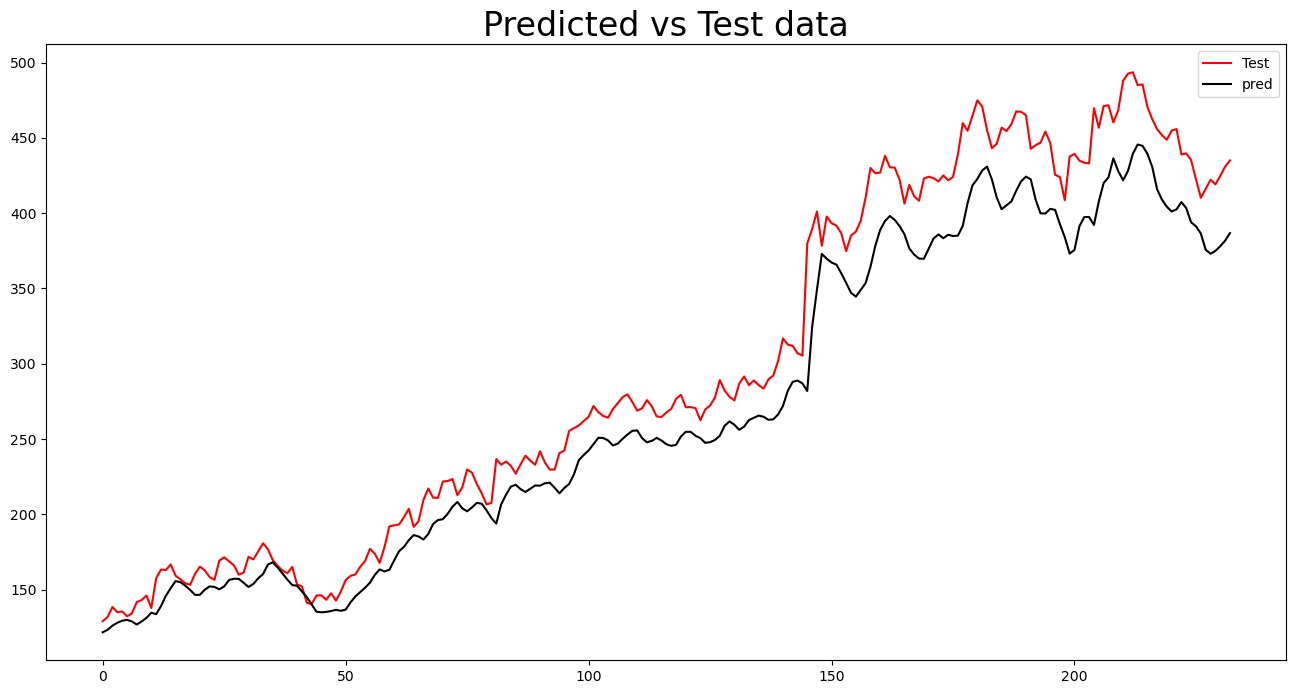

In [71]:
#plot y predicted data onto y test data
plt.figure(figsize=(16,8))
plt.title('Predicted vs Test data', fontsize = 24)
plt.plot(y_test, color = 'red', label = 'Test')
plt.plot(y_pred, color = 'black', label = 'pred')
plt.legend()
plt.show()

In [72]:
trainScore = math.sqrt(mean_squared_error(y_pred[45], y_test[45]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 11.26


# Forecast Future Values

In [76]:
predictions_future = model.predict(X_test[-10:])
predictions_future

1/1 [==============================] - 0s 40ms/step


array([[0.8041253 ],
       [0.78360116],
       [0.7780207 ],
       [0.76756746],
       [0.7440391 ],
       [0.73832244],
       [0.7424681 ],
       [0.7492048 ],
       [0.75727   ],
       [0.7681535 ]], dtype=float32)

In [77]:
#scale back the data to fit the dataset. 
for i in range(10):
    predictions_future[i] = predictions_future[i]*(493.549988-32.900002) + 32.900002
print (predictions_future)

[[403.3203 ]
 [393.86588]
 [391.29523]
 [386.47995]
 [375.6416 ]
 [373.0082 ]
 [374.91794]
 [378.02118]
 [381.73642]
 [386.7499 ]]


In [78]:
df = pd.DataFrame(predictions_future, columns = ['Close'])
df

,Close
0,403.320312
1,393.865875
2,391.295227
3,386.479950
4,375.641602
5,373.008209
6,374.917938
7,378.021179
8,381.736420
9,386.749908


In [79]:
#transfer data to csv
df.to_csv('Han Zixuan Nancy_Project_1.csv')